In [2]:
from numpy import pi, log, sqrt
import getdist
import numpy as np
from io import StringIO
from getdist import plots, MCSamples
import random
from scipy.integrate import quad
from scipy.integrate import odeint
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from scipy import stats
import pypolychord
from pypolychord.settings import PolyChordSettings
from pypolychord.priors import UniformPrior, GaussianPrior
import scipy.optimize as op
from numpy.linalg import inv
from mpi4py import MPI
import sympy as sp
import scipy.linalg as la

In [29]:
#Build Full Covariance Matrix
filename = 'data/HzTable_MM_BC03.dat'
z, Hz, errHz = np.genfromtxt(filename, comments='#', usecols=(0,1,2), unpack=True, delimiter=',')
ref = np.genfromtxt(filename, comments='#', usecols=(3), unpack=True, dtype=str, delimiter=',')


filename = 'data/data_MM20.dat'
zmod, imf, slib, sps, spsooo = np.genfromtxt(filename, comments='#', usecols=(0,1,2,3,4), unpack=True)

cov_mat_diag = np.zeros((len(z), len(z)), dtype='float64')

for i in range(len(z)):
	cov_mat_diag[i,i] = errHz[i]**2

imf_intp = np.interp(z, zmod, imf)/100
slib_intp = np.interp(z, zmod, slib)/100
sps_intp = np.interp(z, zmod, sps)/100
spsooo_intp = np.interp(z, zmod, spsooo)/100

cov_mat_imf = np.zeros((len(z), len(z)), dtype='float64')
cov_mat_slib = np.zeros((len(z), len(z)), dtype='float64')
cov_mat_sps = np.zeros((len(z), len(z)), dtype='float64')
cov_mat_spsooo = np.zeros((len(z), len(z)), dtype='float64')

for i in range(len(z)):
	for j in range(len(z)):
		cov_mat_imf[i,j] = Hz[i] * imf_intp[i] * Hz[j] * imf_intp[j]
		cov_mat_slib[i,j] = Hz[i] * slib_intp[i] * Hz[j] * slib_intp[j]
		cov_mat_sps[i,j] = Hz[i] * sps_intp[i] * Hz[j] * sps_intp[j]
		cov_mat_spsooo[i,j] = Hz[i] * spsooo_intp[i] * Hz[j] * spsooo_intp[j]


cov_mat = cov_mat_spsooo+cov_mat_imf+cov_mat_diag
inv_cov_mat = inv(cov_mat)

cov_mat_cc = inv_cov_mat

In [30]:
# load Pantheon dataset
panthData = np.genfromtxt("data/pantheon_data.txt")
panthData = panthData[np.argsort(panthData[:,0])]

# load Covariance Matrix
cov = np.loadtxt('data/Pantheon_cov_all.cov')
cov_mat = cov.reshape(1701, 1701)
inverse_covar = la.inv(cov_mat)

#loading BAO data
dirBD= "data/desi_gaussian_bao_ALL_GCcomb_mean.txt"
BaoData = np.genfromtxt(dirBD)
xarr = np.array(BaoData[:,0])
yarr = np.array(BaoData[:,1])

funarr = np.genfromtxt(dirBD,dtype='str')[:,2]
print(funarr)

def modelArr(name):
    mod = []

    for j in range(len(funarr)):
        if (funarr[j] == name):
             mod.append([xarr[j],yarr[j]])
    mod = np.array(mod)
    mod = mod[np.argsort(mod[:,0])]
    return mod

cov_bao = np.loadtxt("data/desi_gaussian_bao_ALL_GCcomb_cov.txt")  
cov_bao_inv = np.linalg.inv(cov_bao)

['DVrd' 'DMrd' 'DHrd' 'DMrd' 'DHrd' 'DMrd' 'DHrd' 'DMrd' 'DHrd' 'DMrd'
 'DHrd' 'DHrd' 'DMrd']


In [36]:
#H functions
c = 299792.458

def E(theta,z):
    H0, Om, rd, M = theta
    OL = 1 - Om
    return np.sqrt(Om*(1+z)**3 + OL)

def H(theta,z):
    H0, Om, rd, M = theta
    arr = []
    for j in range(len(z)):
        arr.append(H0*E(theta,z[j]))
    arr = np.array(arr)
    return arr

H([67,0.32,147,-19],[1,2,3])

array([120.6      , 204.5421228, 308.2      ])

In [37]:
#DH functions
def DH(theta,z):
    H0, Om, rd, M = theta
    arr = []
    for j in range(len(z)):
        arr.append(c/(H0*E(theta,z[j])))
    arr = np.array(arr)
    return arr

def DHrd(theta,z):
    H0, Om, rd, M = theta
    arr = []

    for j in range(len(z)):
        arr.append(c/(H0*E(theta,z[j])*rd))
    arr = np.array(arr)
    return arr

DHrd([67,0.32,147,-19],[1,2,3])

array([16.91048488,  9.97058429,  6.61714626])

In [38]:
def Sk(theta,x):
    H0, Om, rd, M = theta
    Ok =0
    if Ok < -10**(-15):
        return np.sin(np.sqrt(-Ok)*x)/np.sqrt(-Ok)
    #if Ok == 0:
    #    return x
    elif Ok > 10**(-15):
        return np.sinh(np.sqrt(Ok)*x)/np.sqrt(Ok)
    else:
        return x

In [39]:
# function that returns dDC/dz,df/dz
def dchidz(x,z, H0, Om, rd, M):
    return 1/E([H0, Om, rd, M],z)

def chiInt(theta,z):
    H0, Om, rd, M = theta
    z = np.hstack((np.array((0)), z))
    arr = odeint(dchidz,0,z,args=(H0, Om, rd, M,))
    return np.delete(arr ,0)

chiInt([67,0.32,147,-19],[1,2,3])

array([0.7624812 , 1.18936468, 1.45585048])

In [40]:
#DM

def DM(theta,z):
    H0, Om, rd, M = theta
    chi = chiInt(theta,z)

    arr = []

    for i in range(len(z)):
        arr.append(c*Sk(theta,chi[i])/H0)
    arr = np.array(arr)
    arr.shape
    return arr

def DMrd(theta,z):
    H0, Om, rd, M = theta
    chi = chiInt(theta,z)

    arr = []

    for i in range(len(z)):
        arr.append(c*Sk(theta,chi[i])/(H0*rd))
    arr = np.array(arr)
    arr.shape
    return arr

DMrd([67,0.32,147,-19],[1,2,3])

array([23.20906838, 36.20292027, 44.31444763])

In [41]:
#DV

def DV(theta,z):
    H0, Om, rd, M = theta
    dh = DH(theta,z)
    dm = DM(theta,z)
    arr = []

    for i in range(len(z)):
        arr.append(np.cbrt(z[i]*dh[i]*dm[i]**2))
    arr = np.array(arr)
    arr.shape
    return arr

def DVrd(theta,z):

    H0, Om, rd, M = theta

    dh = DH(theta,z)
    dm = DM(theta,z)
    arr = []

    for i in range(len(z)):
        arr.append(np.cbrt(z[i]*dh[i]*dm[i]**2)/rd)
    arr = np.array(arr)
    arr.shape
    return arr

DVrd([67,0.32,147,-19],[0.295,0.510,2.330])

array([ 8.09489205, 12.88345356, 31.38816821])

In [42]:
def DL(theta,z):
    H0, Om, rd, M = theta
    chi = chiInt(theta,z)
    return c*chi/H0

def mu(theta,z):
    H0, Om, rd, M = theta
    dL = DL(theta,z)
    mu = []

    for i in range(len(z)):
        mu.append(5*np.log10(dL[i]*(1+z[i])) + 25 + M)
    mu = np.array(mu)
    mu.shape
    return mu

In [43]:
def Omega_Lambda(theta):
    H0, Om, rd, M = theta
    OL = 1 - Om
    return OL

In [44]:
def lnlike(theta,model,z,Hz,cov_mat_cc):
    prediction = model(theta,z)
    residualcc = prediction - Hz
    chi2 = residualcc.T @ cov_mat_cc @ residualcc
    return chi2

def lnlikeCC(theta):
    chi = 0; i = 0
    chi += lnlike(theta, H, z, Hz, cov_mat_cc)
    i += len(z)
    OL = Omega_Lambda(theta)
    return -chi, [i, chi/(i-len(theta)),1-stats.chi2.cdf(x=chi, df=(i-len(theta))),OL]

print(lnlikeCC([67,0.32,147,-19]))

(np.float64(-6.183367402883179), [15, np.float64(0.5621243093530163), np.float64(0.8608533971088996), 0.6799999999999999])


In [45]:
# likelihood with covariance matrix
def lnlikecov(theta, model, x, y, cov):
    prediction = []

    for i in range(len(model)):
        fun = model[i]
        prediction.append(eval(fun)(theta, [x[i]]))
    prediction = np.array(prediction)[:, 0]
    vec = (prediction - y)
    result = np.dot(np.dot(vec, cov), vec.T)
    return result

print(lnlikecov([67, 0.32, 147, -19], funarr, np.array(BaoData[:, 0]), np.array(BaoData[:, 1]), cov_bao_inv))

40.55527665589692


In [46]:
def lnlikeBAO(theta):
    x = np.array(BaoData[:, 0])
    y = np.array(BaoData[:, 1])

    # Use your manually loaded inverse covariance matrix
    chi = lnlikecov(theta, funarr, x, y, cov_bao_inv)
    i = len(x)
    OL = Omega_Lambda(theta)
    return -chi, [chi, chi / (i - len(theta)), 1 - stats.chi2.cdf(x=chi, df=(i - len(theta))), OL]

lnlikeBAO([67,0.32,147,-19])

(np.float64(-40.55527665589692),
 [np.float64(40.55527665589692),
  np.float64(4.506141850655213),
  np.float64(6.0255719672719366e-06),
  0.6799999999999999])

In [47]:
def A(theta, x, y, inverse_covar):
    Mu = mu(theta, x)
    residual = y - Mu
    chi2 = residual.T @ inverse_covar @ residual
    return chi2

def lnlikeSNIa(theta):
    chi = A(theta, panthData[:, 0], panthData[:, 1], inverse_covar)
    i = len(panthData[:, 0])
    OL = Omega_Lambda(theta)
    return -chi, [chi, chi/(i-len(theta)),1-stats.chi2.cdf(x=chi, df=(i-len(theta))),OL]

print(lnlikeSNIa([67,0.32,147,-19]))

(np.float64(-16853.479589103663), [np.float64(16853.479589103663), np.float64(9.93133741255372), np.float64(0.0), 0.6799999999999999])


In [48]:
def lnlikeTot(theta):

    chi = lnlikecov(theta, funarr, np.array(BaoData[:, 0]), np.array(BaoData[:, 1]), cov_bao_inv)
    i = len(BaoData[:, 0])
    chi += lnlike(theta, H, z, Hz, cov_mat_cc); i += len(z)
    chi += A(theta, panthData[:,0], panthData[:,1], inverse_covar);i += len(panthData[:,0])
    OL = Omega_Lambda(theta)
    return -chi, [chi, chi/(i-len(theta)), 1 - stats.chi2.cdf(x=chi, df=(i-len(theta))),OL]

print(lnlikeTot([67,0.32,147,-19]))

(np.float64(-16900.218233162443), [np.float64(16900.218233162443), np.float64(9.79722796125359), np.float64(0.0), 0.6799999999999999])


In [49]:
runs = 100

In [50]:
def dumper(live, dead, logweights, logZ, logZerr):
    print("Last dead point:", dead[-1])

In [51]:
def uniprior(hypercube):
    prior = []
    prior.append(UniformPrior(50.,100.)(hypercube[0]))
    prior.append(UniformPrior(0.,1.)(hypercube[1]))
    prior.append(UniformPrior(100.,200.)(hypercube[2]))
    prior.append(UniformPrior(-20,-18.)(hypercube[3]))
    return prior

In [52]:
settingsTot = PolyChordSettings(4,4)
settingsTot.file_root = 'CC + SNIa + BAO'
settingsTot.nlive = runs
settingsTot.do_clustering = True
settingsTot.read_resume = False

In [53]:
outputTot = pypolychord.run_polychord(lnlikeTot, 4,4, settingsTot, uniprior, dumper)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.22.1
  release: 10th Jan 2024
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     100
nDims    :       4
nDerived :       4
Doing Clustering
Synchronous parallelisation
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file to chains/CC + SNIa + BAO.resume

generating live points


all live points generated

Speed  1 =  0.332E-02 seconds
number of repeats:           20
started sampling

Last dead point: [ 7.01649125e+01  4.39169081e-01  1.26678634e+02 -1.98151816e+01
  2.12701037e+04  1.23304949e+01  0.00000000e+00  5.60830919e-01
 -1.00000000e+30 -2.12701037e+04]
_________________
lives      | 100 |
phantoms   |1165 |
posteriors | 101 |
equals     |   1 |
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
ncluster   =       1 /       1
ndead      =             

In [54]:
paramnames = [('H0','H_{0}'),('Om', r'\Omega_{m0}'),('rd','r_d (Mpc)'),('M',r'\mathcal{M}'),('L',r'L'),('Ldof',r'L/Dof'),('p','p'),('Omega_Lambda', r'\Omega_{\Lambda0}')]
outputTot.make_paramnames_files(paramnames)

posteriorTot = outputTot.posterior

chains/CC + SNIa + BAO.txt
Removed no burn in


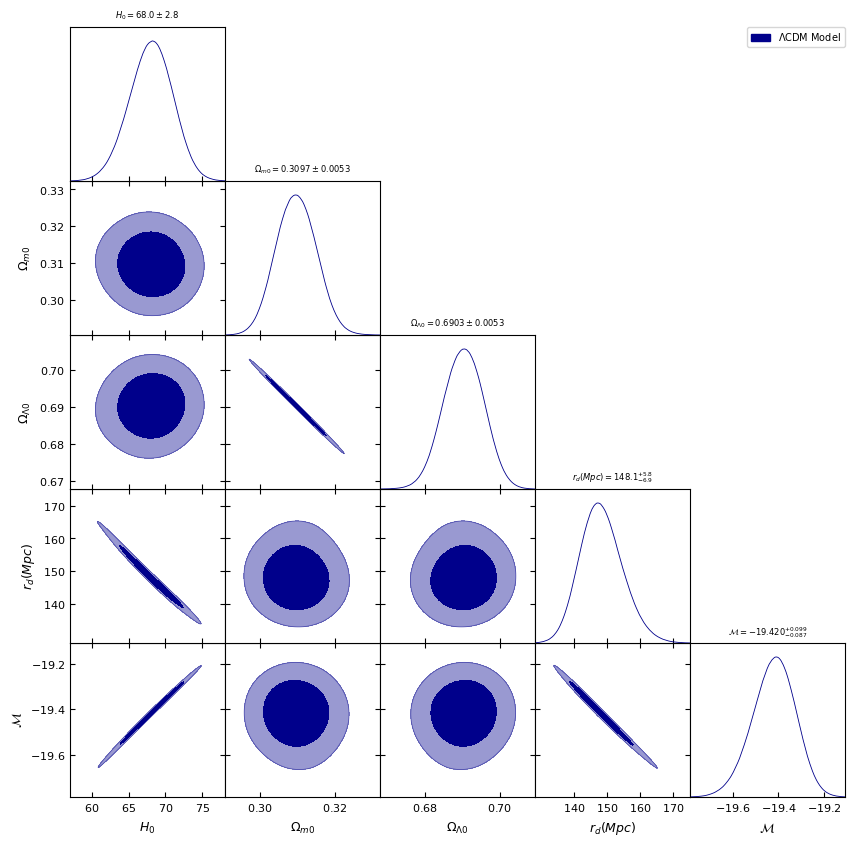

In [55]:
g = getdist.plots.getSubplotPlotter(width_inch=10.0)
g.settings.figure_legend_frame = True  # Remove frame around the legend
g.settings.alpha_filled_add = 0.6  # Adjust transparency of filled contours
g.settings.title_limit_fontsize = 9 # Limit title fontsize to 14
g.settings.axes_labelsize = 12  # Adjust label fontsize
g.settings.legend_fontsize = 10  # Adjust legend fontsize
g.settings.colorbar_axes_fontsize = 10  # Adjust colorbar fontsize
g.triangle_plot([posteriorTot], ('H0','Om','Omega_Lambda','rd','M') ,filled=True, contour_colors=['darkblue'], legend_loc='upper right', legend_labels=[r'$\Lambda$CDM Model'],title_limit=1)
g.export("fig_1.pdf")

In [57]:
def get_constraints(samples):
    for i, mean in enumerate(samples.getMeans()):
        upper = samples.confidence(i, upper=True, limfrac=0.05)
        #print("\nupper limit 95 C.L. = %f" % upper)
        lower = samples.confidence(i, upper=False, limfrac=0.05)
        #print("lower limit 95 C.L. = %f" % lower)
        print("%s = %f +/- %f +/- %f" % (samples.parLabel(i),\

        mean, mean - samples.confidence(i, limfrac=0.16),\
        mean - samples.confidence(i, limfrac=0.025)) )
    return
for i in ["Tot"]:
    print(i)
    get_constraints(eval("posterior"+i))

Tot
H_{0} = 68.044859 +/- 2.946328 +/- 5.888328
\Omega_{m0} = 0.309685 +/- 0.005271 +/- 0.009447
r_d (Mpc) = 148.090615 +/- 6.447757 +/- 10.654155
\mathcal{M} = -19.419623 +/- 0.094009 +/- 0.195150
L = 1756.555497 +/- 1.218888 +/- 1.656820
L/Dof = 1.018293 +/- 0.000707 +/- 0.000960
p = 0.292817 +/- 0.006531 +/- 0.020597
\Omega_{\Lambda0} = 0.690315 +/- 0.005261 +/- 0.010209
